# Black-Box Query Membership Inference Attack Demo
This notebook demonstrates a black-box query attack for membership inference using input perturbations.

The black-box query membership inference attack works by probing a trained model (the "victim") with modified versions of its input data and observing how its predictions change. Here’s how it works in your notebook:

- Setup: You train a victim model (MLPClassifier) on some data. Some data points are in the training set ("members"), others are not ("non-members").

- Perturbation: For each input, you randomly drop words from the text (using drop_prob) to create a perturbed version.

- Querying: You feed both the original and perturbed inputs to the victim model and record its predictions.

- Scoring: For each input, you check if the prediction changes after perturbation. If the prediction stays the same, you assign a score of 1; if it changes, a score of 0.

- Inference: The idea is that the model is more "confident" (less sensitive to perturbation) on data it has seen during training (members) than on unseen data (non-members). So, members tend to have higher scores.

- Attack Evaluation: By comparing scores for members and non-members, you try to distinguish between them. You plot ROC curves and compute AUC to measure how well the attack works.

Summary: The attack exploits the difference in model behavior between training and non-training data. If the model is more stable on members, you can infer membership by checking prediction stability after input perturbation. This is done without access to the model’s internals—only by querying it, hence "black-box."

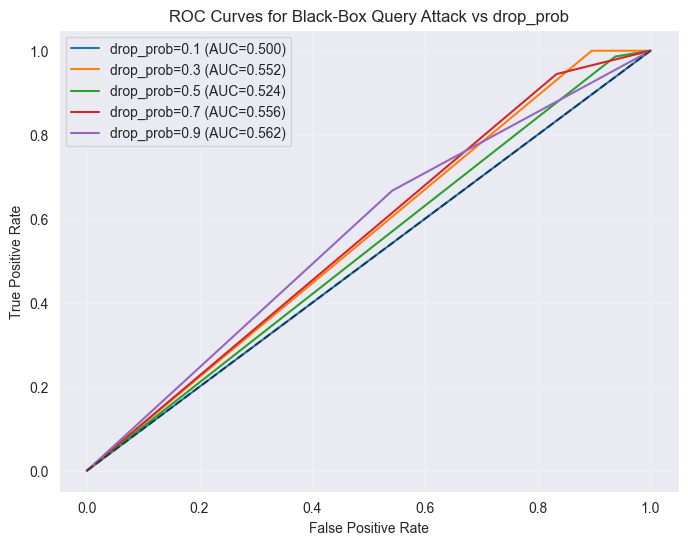

In [1]:
# Black-Box Query Membership Inference Attack: ROC & AUC Only
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve

LABEL_COL = "interview_round"  # or your actual label column name
df = pd.read_csv("EduPilot_dataset.csv")  # update path if needed
df = df.dropna(subset=[LABEL_COL])
label_words = sorted(df[LABEL_COL].unique())
label_to_id = {w: i for i, w in enumerate(label_words)}

y = df[LABEL_COL].map(label_to_id).astype(int).values
text_cols = ["user_query", "job_role", "company", "location", "mock_question"]
df["text"] = df[text_cols].fillna("").agg(" | ".join, axis=1)

# Train/test split
indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.40, stratify=y, random_state=42)

# Victim model
vec = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X = vec.fit_transform(df["text"])
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
victim = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=123)
victim.fit(X_train, y_train)

# Perturbation function
def perturb_text(text, drop_prob=0.5):
    words = text.split()
    keep = np.random.rand(len(words)) > drop_prob
    return ' '.join([w for w, k in zip(words, keep) if k])

# ROC/AUC analysis for different drop_prob
from sklearn.metrics import roc_curve, roc_auc_score

# Sweep drop_prob and plot ROC curves
drop_probs = [0.1, 0.3, 0.5, 0.7, 0.9]
plt.figure(figsize=(8,6))
orig_pred_train = victim.predict(X_train)
orig_pred_test = victim.predict(X_test)
for drop_prob in drop_probs:
    perturbed_texts_train = [perturb_text(t, drop_prob=drop_prob) for t in df.iloc[train_idx]["text"]]
    perturbed_texts_test  = [perturb_text(t, drop_prob=drop_prob) for t in df.iloc[test_idx]["text"]]
    X_train_pert = vec.transform(perturbed_texts_train)
    X_test_pert  = vec.transform(perturbed_texts_test)
    pert_pred_train = victim.predict(X_train_pert)
    pert_pred_test  = victim.predict(X_test_pert)
    score_train = (orig_pred_train == pert_pred_train).astype(float)
    score_test  = (orig_pred_test  == pert_pred_test ).astype(float)
    is_member = np.concatenate([np.ones_like(score_train), np.zeros_like(score_test)])
    scores = np.concatenate([score_train, score_test])
    auc = roc_auc_score(is_member, scores)
    fpr, tpr, _ = roc_curve(is_member, scores)
    plt.plot(fpr, tpr, label=f'drop_prob={drop_prob} (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Black-Box Query Attack vs drop_prob')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The ROC curve in your plot is almost a straight line (close to the diagonal from (0,0) to (1,1)), rather than a curved shape. This means the attack is not able to distinguish members from non-members much better than random guessing.

- The attack score (fraction of unchanged predictions after perturbation) is similar for both members and non-members.
- The victim model (MLPClassifier) is not sensitive enough to input perturbations, or the attack method does not create a strong difference between member and non-member behavior.
- As a result, when you sweep the decision threshold, the true positive rate and false positive rate increase together, producing a nearly straight line.

## Train Victim Model
Train a logistic regression classifier as the victim model.

In [5]:
victim = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=123)
victim.fit(X_train, y_train)

def per_example_loss(model, Xmat, y_true, eps=1e-12):
    proba = model.predict_proba(Xmat)
    rows = np.arange(Xmat.shape[0])
    p_true = np.clip(proba[rows, y_true], eps, 1.0-eps)
    return -np.log(p_true)

train_losses = per_example_loss(victim, X_train, y_train)
test_losses = per_example_loss(victim, X_test, y_test)
print(f"Victim train mean loss: {train_losses.mean():.4f}")
print(f"Victim test mean loss: {test_losses.mean():.4f}")

Victim train mean loss: 0.0086
Victim test mean loss: 0.0966


## Black-Box Query Attack
Perturb input text and observe changes in victim model predictions to infer membership.

Black-box query attack ROC-AUC: 0.5312


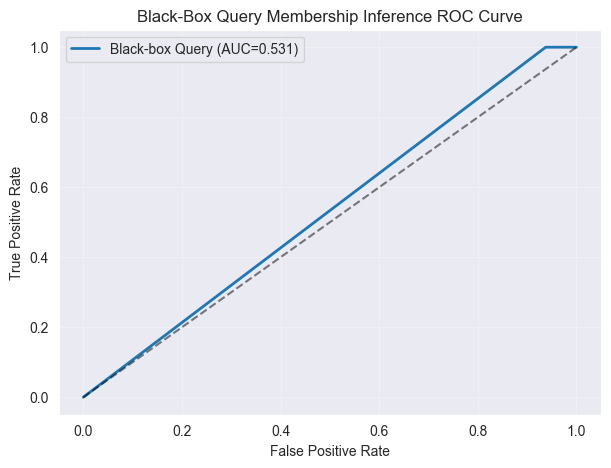

In [6]:
# Simple black-box query attack: perturb input and measure prediction stability
# For demonstration, randomly drop words from the text and see if prediction changes

def perturb_text(text, drop_prob=0.5):  # Try a stronger perturbation
    words = text.split()
    keep = np.random.rand(len(words)) > drop_prob
    return ' '.join([w for w, k in zip(words, keep) if k])

# Get original predictions
orig_pred_train = victim.predict(X_train)
orig_pred_test = victim.predict(X_test)

# Perturb each input and get new predictions
perturbed_texts_train = [perturb_text(t) for t in df.iloc[train_idx]["text"]]
perturbed_texts_test  = [perturb_text(t) for t in df.iloc[test_idx]["text"]]

X_train_pert = vec.transform(perturbed_texts_train)
X_test_pert  = vec.transform(perturbed_texts_test)
pert_pred_train = victim.predict(X_train_pert)
pert_pred_test  = victim.predict(X_test_pert)

# Score: fraction of times prediction is unchanged (higher for members)
score_train = (orig_pred_train == pert_pred_train).astype(float)
score_test  = (orig_pred_test  == pert_pred_test ).astype(float)

is_member = np.concatenate([np.ones_like(score_train), np.zeros_like(score_test)])
scores = np.concatenate([score_train, score_test])

auc = roc_auc_score(is_member, scores)
fpr, tpr, _ = roc_curve(is_member, scores)
print(f"Black-box query attack ROC-AUC: {auc:.4f}")
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Black-box Query (AUC={auc:.3f})', lw=2)
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Black-Box Query Membership Inference ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Sweeping drop_prob and max_features
We will vary both the input perturbation strength (`drop_prob`) and the TF-IDF vectorizer's `max_features` parameter, keeping other settings fixed. For each combination, we will plot the ROC curve and report the AUC to analyze the effect on attack effectiveness.

max_features=500, drop_prob=0.2: ROC-AUC=0.5312
max_features=500, drop_prob=0.4: ROC-AUC=0.5521
max_features=500, drop_prob=0.6: ROC-AUC=0.5451
max_features=500, drop_prob=0.8: ROC-AUC=0.6458
max_features=1000, drop_prob=0.2: ROC-AUC=0.5417
max_features=1000, drop_prob=0.4: ROC-AUC=0.5729
max_features=1000, drop_prob=0.6: ROC-AUC=0.5174
max_features=1000, drop_prob=0.8: ROC-AUC=0.6146
max_features=2000, drop_prob=0.2: ROC-AUC=0.5208
max_features=2000, drop_prob=0.4: ROC-AUC=0.5417
max_features=2000, drop_prob=0.6: ROC-AUC=0.5417
max_features=2000, drop_prob=0.8: ROC-AUC=0.5312


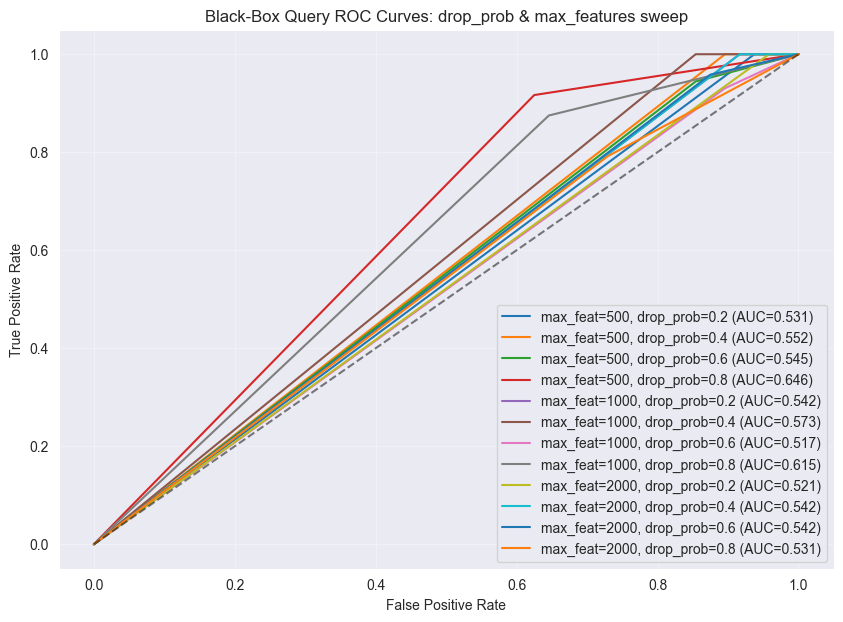

In [7]:
# Sweep drop_prob and max_features, plot ROC curves for each combination
drop_probs = [0.2, 0.4, 0.6, 0.8]
max_features_list = [500, 1000, 2000]
plt.figure(figsize=(10,7))
for max_features in max_features_list:
    vec = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
    X = vec.fit_transform(df["text"])
    X_train, X_test = X[train_idx], X[test_idx]
    victim.fit(X_train, y_train)
    orig_pred_train = victim.predict(X_train)
    orig_pred_test = victim.predict(X_test)
    for drop_prob in drop_probs:
        perturbed_texts_train = [perturb_text(t, drop_prob=drop_prob) for t in df.iloc[train_idx]["text"]]
        perturbed_texts_test  = [perturb_text(t, drop_prob=drop_prob) for t in df.iloc[test_idx]["text"]]
        X_train_pert = vec.transform(perturbed_texts_train)
        X_test_pert  = vec.transform(perturbed_texts_test)
        pert_pred_train = victim.predict(X_train_pert)
        pert_pred_test  = victim.predict(X_test_pert)
        score_train = (orig_pred_train == pert_pred_train).astype(float)
        score_test  = (orig_pred_test  == pert_pred_test ).astype(float)
        is_member = np.concatenate([np.ones_like(score_train), np.zeros_like(score_test)])
        scores = np.concatenate([score_train, score_test])
        auc = roc_auc_score(is_member, scores)
        fpr, tpr, _ = roc_curve(is_member, scores)
        plt.plot(fpr, tpr, label=f'max_feat={max_features}, drop_prob={drop_prob} (AUC={auc:.3f})')
        print(f"max_features={max_features}, drop_prob={drop_prob}: ROC-AUC={auc:.4f}")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Black-Box Query ROC Curves: drop_prob & max_features sweep")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()